In [ ]:
!pip install wandb

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tempfile
import joblib
import wandb
import os

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist

In [ ]:
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Carregando os exemplos

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
samples, w, h = x_train.shape

print(f'{samples} in the training dataset with dimension {w}x{h}')

samples, w, h = x_test.shape

print(f'{samples} in the test dataset with dimension {w}x{h}')

60000 in the training dataset with dimension 28x28
10000 in the test dataset with dimension 28x28


## EDA

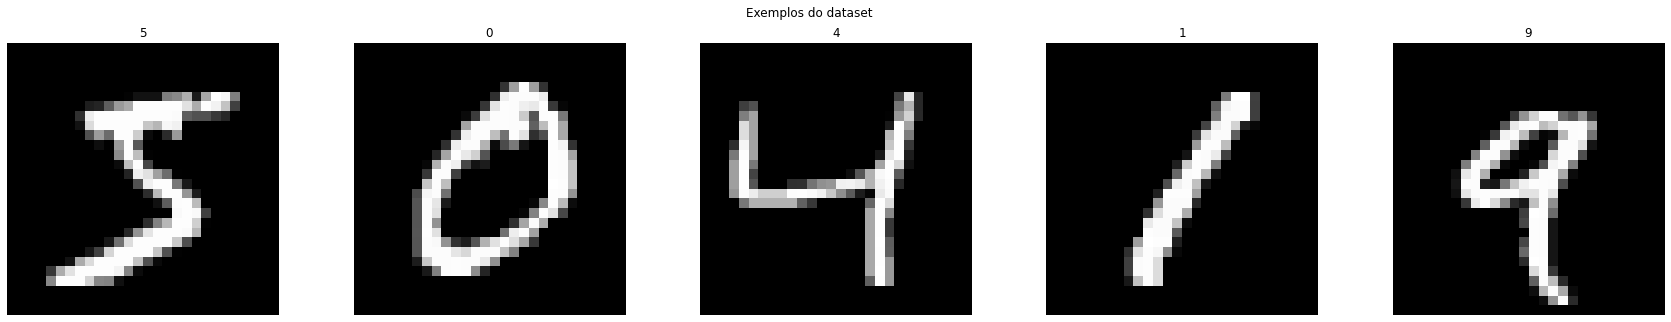

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(30, 5))

for idx, image in enumerate(x_train[:5]):

    ax[idx].imshow(image, cmap='gray')
    ax[idx].axis('off')

    ax[idx].set_title(f'{y_train[idx]}')

fig.suptitle('Exemplos do dataset')

plt.show()

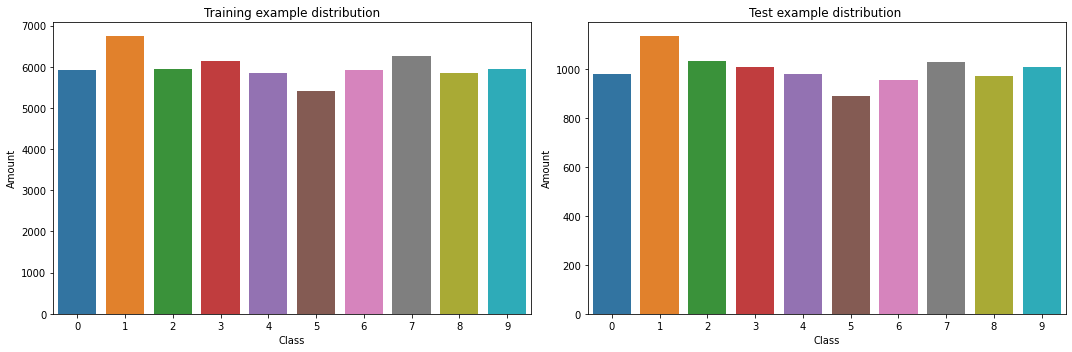

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

sns.countplot(x=y_train, ax=ax[0])
ax[0].set(
    title='Training example distribution',
    xlabel='Class',
    ylabel='Amount'
)

sns.countplot(x=y_test, ax=ax[1])
ax[1].set(
    title='Test example distribution ',
    xlabel='Class',
    ylabel='Amount'
)

plt.tight_layout()
plt.show()

In [ ]:
# Planifica os exemplos
def reshape(array: np.array) -> np.array:
    samples, w, h = array.shape

    return array.reshape((samples, w * h))

x_train = reshape(x_train)
x_test = reshape(x_test)

## Baseline model

In [ ]:
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       980
           1       0.95      0.96      0.95      1135
           2       0.85      0.84      0.84      1032
           3       0.82      0.84      0.83      1010
           4       0.86      0.85      0.86       982
           5       0.84      0.80      0.82       892
           6       0.91      0.87      0.89       958
           7       0.90      0.88      0.89      1028
           8       0.80      0.81      0.80       974
           9       0.81      0.86      0.83      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.87      0.87     10000



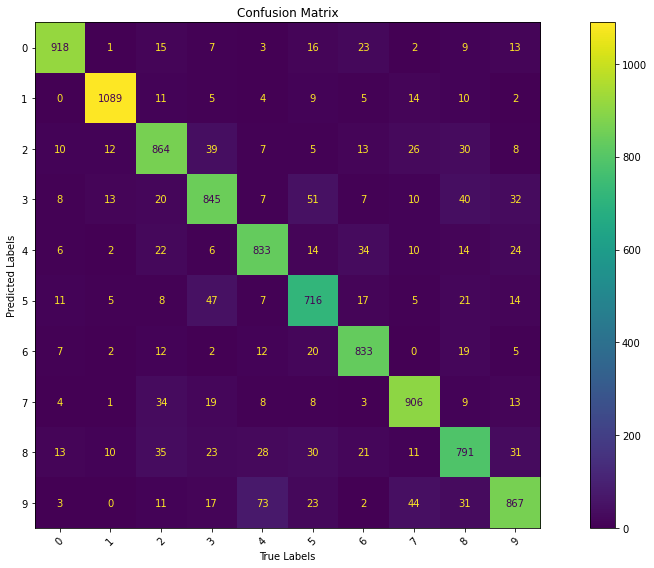

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
run = wandb.init(project='proj_mnist', job_type='train')

print('Evaluating Model...')

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1, average='weighted')
precision = precision_score(y_test, y_pred, zero_division=1, average='weighted')
recall = recall_score(y_test, y_pred, zero_division=1, average='weighted')
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {fbeta}')

run.summary['Acc'] = acc
run.summary['Precision'] = precision
run.summary['Recall'] = recall
run.summary['F1'] = fbeta

print('Uploading confusion matrix...')

run.log({
    'confusion_matrix': wandb.Image(fig)
})

wandb.sklearn.plot_classifier(
    clf, 
    x_train, x_test,
    y_train, y_test, y_pred,
    clf.predict_proba(x_test),
    np.unique(y_train), 
    model_name='Baseline_model'
)

wandb.sklearn.plot_summary_metrics(
    clf,
    x_train, y_train,
    x_test, y_test
)

# ROC curve
predict_proba = clf.predict_proba(x_test)
wandb.sklearn.plot_roc(y_test, predict_proba, np.unique(y_train))

run.finish()

Evaluating Model...
Accuracy: 0.8662
Precision: 0.8667235267962755
Recall: 0.8662
F1: 0.866231140344577
Uploading confusion matrix...


wandb: 
wandb: Plotting Baseline_model.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


Acc,0.8662
F1,0.86623
Precision,0.86672
Recall,0.8662


In [ ]:
run = wandb.init(project='proj_mnist', job_type='model')

artifact_model = 'model_export'

print('Dumping model to disk...')

joblib.dump(clf, artifact_model)

artifact = wandb.Artifact(
    artifact_model,
    type='inference_artifact',
    description='Model for inference'
)

print('Logging model artifact...')
artifact.add_file(artifact_model)
run.log_artifact(artifact)

run.finish()

Dumping model to disk...
Logging model artifact...


## Redução de dimensionalidade com TSVD e TSNE

In [ ]:
tsvd = TruncatedSVD(n_components=50)
tsvd_data = tsvd.fit_transform(np.concatenate([x_train, x_test]))

In [ ]:
tsne_data = TSNE().fit_transform(tsvd_data)

In [ ]:
import pandas as pd

tsne_df = pd.DataFrame(tsne_data, columns=['x1', 'x2'])
tsne_df['label'] = np.concatenate([y_train, y_test])

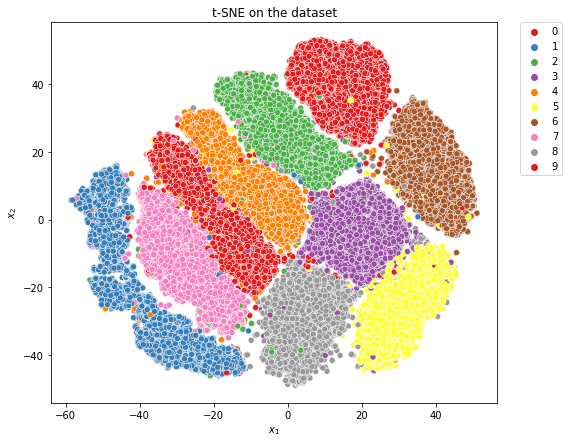

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

sns.scatterplot(
    data=tsne_df,
    x='x1',
    y='x2',
    hue=tsne_df['label'],
    palette='Set1',
    legend='full',
    ax=ax
)

ax.set(
    title='t-SNE on the dataset',
    xlabel='$x_1$',
    ylabel='$x_2$'
)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    tsne_data, tsne_df['label'], 
    test_size=0.2, 
    stratify=tsne_df['label'], 
    random_state=42
)

In [ ]:
np.column_stack((x_train, y_train))

array([[  5.5106215,  39.63263  ,   0.       ],
       [-22.247297 , -17.219711 ,   7.       ],
       [ 16.294323 ,  28.148628 ,   0.       ],
       ...,
       [-50.505684 ,   1.3710463,   1.       ],
       [-23.902489 ,  12.22765  ,   9.       ],
       [-36.1995   ,   1.6464438,   7.       ]], dtype=float32)

In [ ]:
run = wandb.init(project='proj_mnist', job_type='split_data')
artifact_input_name = 'proj_mnist/preprocessed_data.csv:latest'

train_data = (
    'train',
    pd.DataFrame(np.column_stack((x_train, y_train)), columns=['x1', 'x2', 'label'])
)

test_data = (
    'test',
    pd.DataFrame(np.column_stack((x_test, y_test)), columns=['x1', 'x2', 'label'])
)

with tempfile.TemporaryDirectory() as tmp_dir:

    for split, df in [train_data, test_data]:

        # Make the artifact name from the name of the split plus the provided root
        artifact_name = f'{split}.csv'

        # Get the path on disk within the temp directory
        temp_path = os.path.join(tmp_dir, artifact_name)

        print(f'Uploading the {split} dataset to {artifact_name}')

        # Save then upload to W&B
        df.to_csv(temp_path, index=False)

        artifact = wandb.Artifact(
            name=artifact_name,
            type='segregated_data',
            description=f'{split} split of dataset {artifact_input_name}'
        )
        artifact.add_file(temp_path)

        print('Logging artifact')
        run.log_artifact(artifact)

        # This waits for the artifact to be uploaded to W&B. If you
        # do not add this, the temp directory might be removed before
        # W&B had a chance to upload the datasets, and the upload
        # might fail
        artifact.wait()

run.finish()

In [ ]:
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1381
           1       0.98      0.98      0.98      1575
           2       0.97      0.97      0.97      1398
           3       0.98      0.96      0.97      1428
           4       0.98      0.94      0.96      1365
           5       0.97      0.97      0.97      1263
           6       0.97      0.99      0.98      1375
           7       0.96      0.96      0.96      1459
           8       0.98      0.96      0.97      1365
           9       0.92      0.95      0.93      1391

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



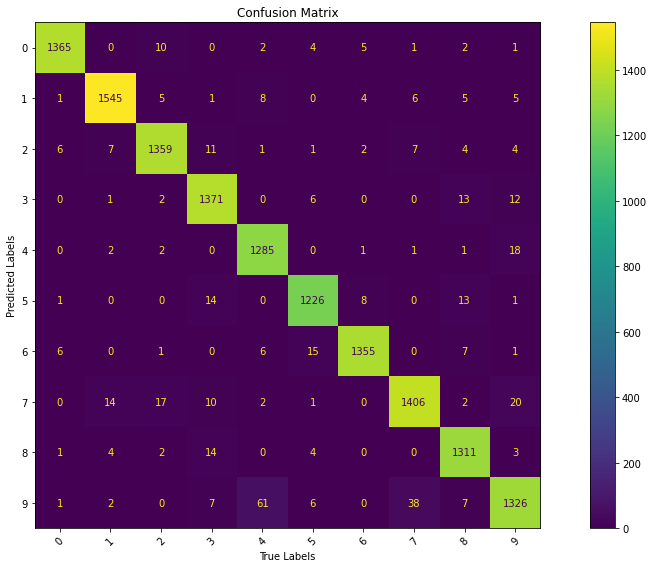

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Redução de dimensionalidade com Autoencoder

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim   
        
        self.encoder = Sequential([
            Dense(512, activation='leaky_relu'),
            Dropout(0.1),
            Dense(256, activation='leaky_relu'),
            Dropout(0.1),
            Dense(128, activation='leaky_relu'),
            Dropout(0.1),
            Dense(64, activation='leaky_relu'),
            Dropout(0.1),
            Dense(latent_dim, activation='leaky_relu'),
        ])

        self.decoder = Sequential([
            Dense(64, activation='leaky_relu'),
            Dropout(0.1),
            Dense(128, activation='leaky_relu'),
            Dropout(0.1),
            Dense(256, activation='leaky_relu'),
            Dropout(0.1),
            Dense(512, activation='leaky_relu'),
            Dropout(0.1),
            Dense(784, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [ ]:
autoencoder = Autoencoder(32)

autoencoder.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
history = autoencoder.fit(
    x_train, x_train,
    validation_split=0.1,
    batch_size=64,
    epochs=100,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
    ]
)


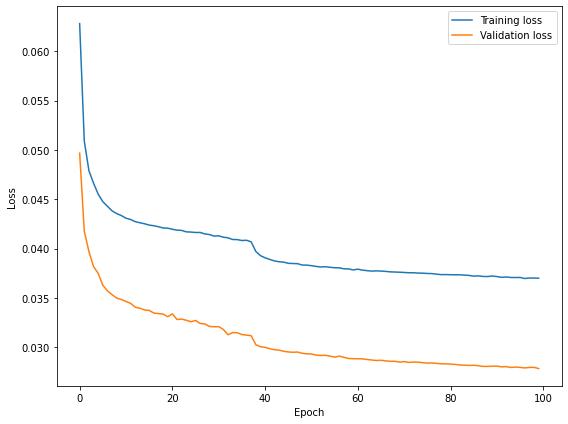

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')

ax.legend()
ax.set(
    ylabel='Loss',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
encoded_train_imgs = autoencoder.encoder(x_train).numpy()

encoded_test_imgs = autoencoder.encoder(x_test).numpy()
decoded_test_imgs = autoencoder.decoder(encoded_test_imgs).numpy()

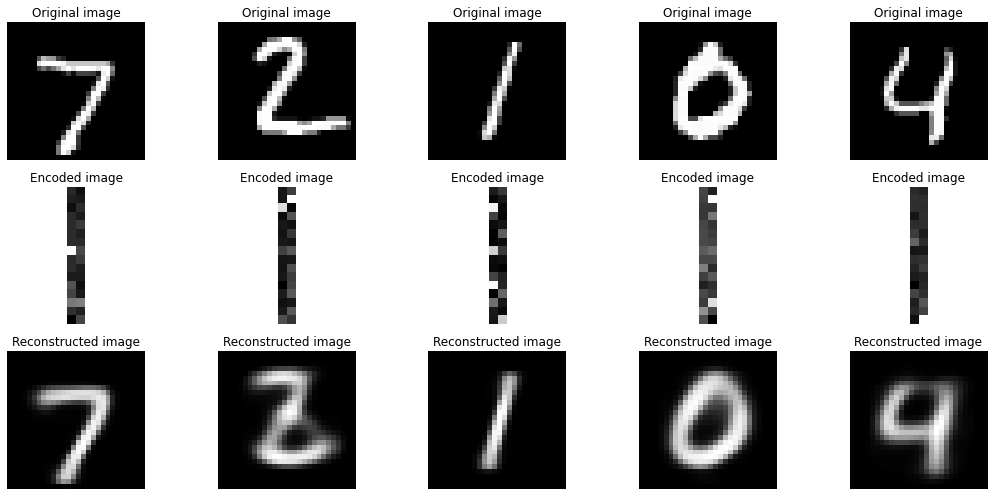

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 7))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(x_test[idx].reshape(28, 28), cmap='gray')

    ax[0][idx].set_title('Original image')
    
    ax[0][idx].axis('off')

    #Encoded imgae
    ax[1][idx].imshow(encoded_test_imgs[idx].reshape(16, 2), cmap='gray')

    ax[1][idx].set_title('Encoded image')
    
    ax[1][idx].axis('off')


    # Reconstructed image
    ax[2][idx].imshow(decoded_test_imgs[idx].reshape(28, 28), cmap='gray')

    ax[2][idx].set_title('Reconstructed image')
    
    ax[2][idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
clf = DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
parameters = {
    'splitter': ['best', 'random'],
    'max_depth': [1, 3, 5, 7, 9, 11, 12],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': ['auto', 'log2', 'sqrt', None],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90] 
}

tuned_model = GridSearchCV(
    clf, param_grid=parameters, 
    scoring='neg_mean_squared_error', 
    cv=5, verbose=3
).fit(encoded_train_imgs, y_train)

In [ ]:
tuned_model.best_params_

{'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [ ]:
y_pred = clf.predict(encoded_test_imgs)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       980
           1       0.98      0.98      0.98      1135
           2       0.87      0.88      0.88      1032
           3       0.87      0.85      0.86      1010
           4       0.66      0.77      0.71       982
           5       0.79      0.79      0.79       892
           6       0.91      0.92      0.92       958
           7       0.90      0.86      0.88      1028
           8       0.84      0.80      0.82       974
           9       0.68      0.62      0.65      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



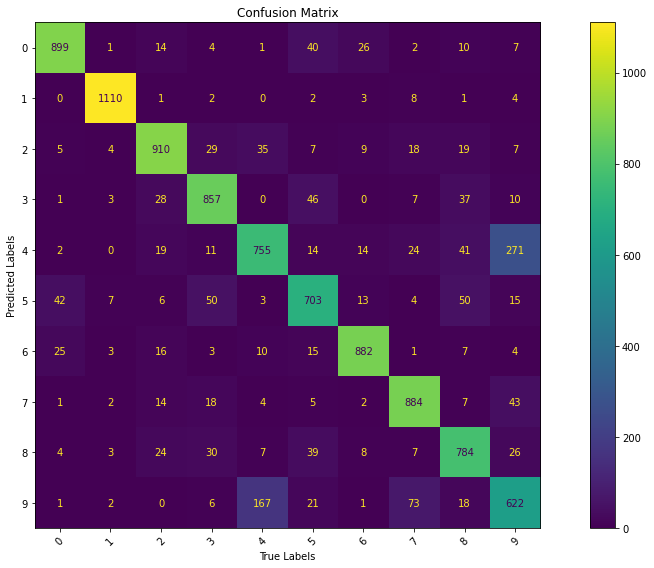

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Test

In [ ]:
input = np.random.rand(1, 784)

In [ ]:
input.shape

(1, 784)

In [ ]:
artifact_model_name = 'proj_mnist/model_export:latest'

run = wandb.init(project='proj_mnist', job_type='api')

model_export_path = run.use_artifact(artifact_model_name).file()
clf = joblib.load(model_export_path)

wandb: Currently logged in as: xarmison. Use `wandb login --relogin` to force relogin


In [ ]:
y_pred = clf.predict_proba(input)

In [ ]:
y_pred[0]

array([9.82961992e-01, 0.00000000e+00, 2.62123198e-03, 7.86369594e-04,
       1.31061599e-03, 2.09698558e-03, 7.33944954e-03, 7.86369594e-04,
       0.00000000e+00, 2.09698558e-03])